In [36]:
# Script 2: Main Analysis - Theta Component Extraction
import numpy as np
import mne
from scipy import signal, linalg

# Load the simulated EEG data
file_path = r"C:\Users\fedor\simulated_eeg_raw.fif"
raw = mne.io.read_raw_fif(file_path, preload=True)
data = raw.get_data()
srate = raw.info['sfreq']

def filterFGx(data, srate, center_freq, half_width):
    """
    Filter data around center frequency with specified bandwidth
    """
    nyq = srate/2
    lower_freq = center_freq - half_width
    upper_freq = center_freq + half_width
    b, a = signal.butter(2, [lower_freq/nyq, upper_freq/nyq], btype='band')
    return signal.filtfilt(b, a, data)

def regularize_cov(cov, reg_lambda=0.01):
    """
    Regularize covariance matrix by adding small constant to diagonal
    """
    return cov + reg_lambda * np.mean(np.diag(cov)) * np.eye(cov.shape[0])

# Theta frequency and bandwidth
theta_freq = 6
theta_width = 2.5

# Theta covariance
thetafilt = filterFGx(data, srate, theta_freq, theta_width)
thetafilt = thetafilt - np.mean(thetafilt, axis=1, keepdims=True)
thetacov = (thetafilt @ thetafilt.T) / data.shape[1]

# Broadband covariance
tmpdat = data - np.mean(data, axis=1, keepdims=True)
bbcov = (tmpdat @ tmpdat.T) / data.shape[1]

# Regularize covariance matrices
thetacov_reg = regularize_cov(thetacov)
bbcov_reg = regularize_cov(bbcov)

# GED
evals, evecs = linalg.eigh(thetacov_reg, bbcov_reg)

# Find best component
maxcomp = np.argsort(evals)
thetamap = thetacov @ evecs  # Use original (non-regularized) covariance for maps
thetamap = thetamap[:, maxcomp[-1]]

# Fix sign of map (max is positive)
maxe = np.argmax(np.abs(thetamap))
thetamap = thetamap * np.sign(thetamap[maxe])

# Theta time series component
thetacomp = thetafilt.T @ evecs[:, maxcomp[-1]]

# Fix sign based on correlation with filtered EEG
filtered_eeg = filterFGx(data[maxe, :], srate, theta_freq, theta_width)
thetacomp = thetacomp * np.sign(np.corrcoef(thetacomp, filtered_eeg)[0,1])

print("=== Theta Component Extraction ===")
print(f"Shape of theta component: {thetacomp.shape}")
print(f"Shape of theta map: {thetamap.shape}")

# Print some additional verification
print("\n=== Component Properties ===")
print(f"Number of eigenvalues: {len(evals)}")
print(f"Range of eigenvalues: {evals.min():.2f} to {evals.max():.2f}")

Opening raw data file C:\Users\fedor\simulated_eeg_raw.fif...
Isotrak not found
    Range : 0 ... 10240 =      0.000 ...    10.000 secs
Ready.
Reading 0 ... 10240  =      0.000 ...    10.000 secs...
=== Theta Component Extraction ===
Shape of theta component: (10241,)
Shape of theta map: (64,)

=== Component Properties ===
Number of eigenvalues: 64
Range of eigenvalues: 0.00 to 0.71


In [ ]:
THETA COMPONENT TIME SERIES

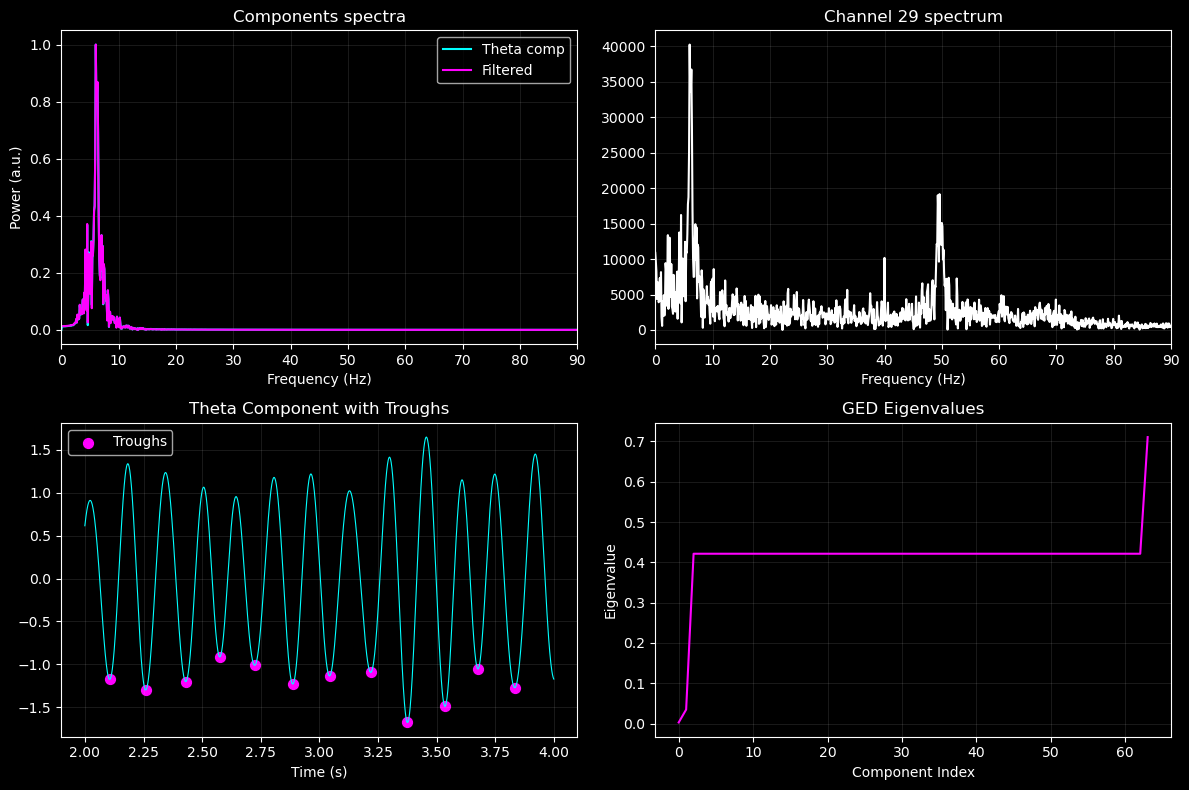

In [26]:
plt.style.use('dark_background')

# Create figure with subplots - reduced to what we need
fig, axs = plt.subplots(2, 2, figsize=(12, 8), facecolor='black')

# Calculate frequencies and FFT
freqs = np.fft.fftfreq(len(thetacomp), 1/srate)
freqs = freqs[:len(freqs)//2]  
theta_fft = np.abs(np.fft.fft(thetacomp))[:len(freqs)]
filtered_eeg_fft = np.abs(np.fft.fft(filtered_eeg))[:len(freqs)]

# Top row
# 1. Components spectra
axs[0,0].plot(freqs, theta_fft/theta_fft.max(), 'cyan', label='Theta comp')
axs[0,0].plot(freqs, filtered_eeg_fft/filtered_eeg_fft.max(), 'magenta', label='Filtered')
axs[0,0].set_xlim(0, 90)
axs[0,0].set_title('Components spectra')
axs[0,0].set_xlabel('Frequency (Hz)')
axs[0,0].set_ylabel('Power (a.u.)')
axs[0,0].legend()
axs[0,0].grid(True, alpha=0.1)

# 2. Channel spectrum
ch_fft = np.abs(np.fft.fft(data[maxe,:]))[:len(freqs)]
axs[0,1].plot(freqs, ch_fft, 'white')
axs[0,1].set_xlim(0, 90)
axs[0,1].set_title(f'Channel {maxe} spectrum')
axs[0,1].set_xlabel('Frequency (Hz)')
axs[0,1].grid(True, alpha=0.1)

# Bottom row
# 1. Theta component with detected troughs
segment = slice(int(2*srate), int(4*srate))
times_segment = times[segment]
axs[1,0].plot(times_segment, thetacomp[segment], 'cyan', linewidth=0.8)

# Find troughs in segment
diff1 = np.diff(thetacomp[segment])
diff2 = np.diff(np.sign(diff1))
troughs_segment = np.where(diff2 > 0)[0] + 1
axs[1,0].scatter(times_segment[troughs_segment], thetacomp[segment][troughs_segment], 
                color='magenta', s=50, label='Troughs')

axs[1,0].set_title('Theta Component with Troughs')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].legend()
axs[1,0].grid(True, alpha=0.1)

# 2. Eigenvalue spectrum
axs[1,1].plot(np.sort(evals), 'magenta')
axs[1,1].set_title('GED Eigenvalues')
axs[1,1].set_xlabel('Component Index')
axs[1,1].set_ylabel('Eigenvalue')
axs[1,1].grid(True, alpha=0.1)

plt.tight_layout()
plt.show()

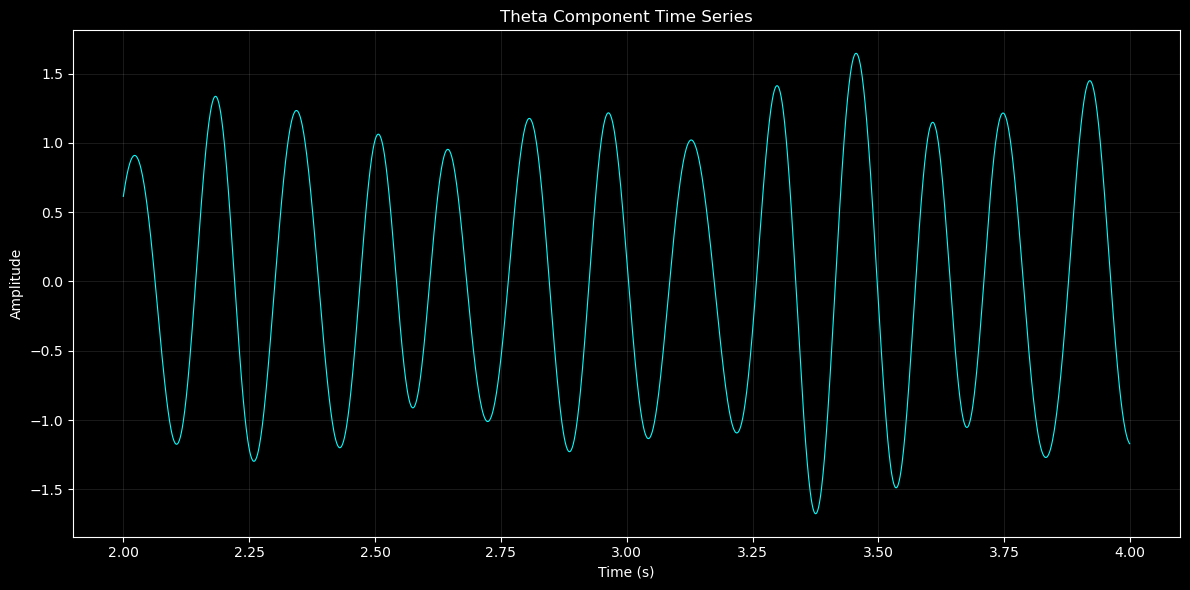


=== Component Statistics ===
Theta component mean: -0.000
Theta component std: 0.842
Theta component range: -1.676 to 1.649


In [20]:
# Plot results with just time series
import matplotlib.pyplot as plt
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 6), facecolor='black')

# Create time vector
times = np.arange(len(thetacomp)) / srate

# Time series plot - show a 2-second segment
segment = slice(int(2*srate), int(4*srate))
ax.plot(times[segment], thetacomp[segment], color='cyan', linewidth=0.8)
ax.set_title('Theta Component Time Series')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.grid(True, alpha=0.1)
ax.set_facecolor('black')

# Adjust the spines
for spine in ax.spines.values():
    spine.set_color('white')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')

plt.tight_layout()
plt.show()

# Print some additional verification stats
print("\n=== Component Statistics ===")
print(f"Theta component mean: {np.mean(thetacomp):.3f}")
print(f"Theta component std: {np.std(thetacomp):.3f}")
print(f"Theta component range: {np.min(thetacomp):.3f} to {np.max(thetacomp):.3f}")

THROUGHS AND PAC

In [22]:
# Parameters setup
nwin = int(np.ceil(srate/theta_freq/8))  # window calculation
n_timepoints = len(thetacomp)  # get number of timepoints from thetacomp

# Find troughs exactly as MATLAB does
diff1 = np.diff(thetacomp)
diff2 = np.diff(np.sign(diff1))
troughs = np.where(diff2 > 0)[0] + 1

# Remove edge troughs exactly as MATLAB
troughs = troughs[(troughs > nwin) & (troughs < n_timepoints - nwin - 1)]

# Compute trough-locked covariance exactly as MATLAB
covT = np.zeros((data.shape[0], data.shape[0]))
for ti, trough in enumerate(troughs, 1):
    tmpdat = data[:, trough-nwin:trough+nwin]
    tmpdat = tmpdat - np.mean(tmpdat, axis=1, keepdims=True)
    covT += (tmpdat @ tmpdat.T)/nwin

covT = covT/len(troughs)

# Print comparison info
print("=== Trough Detection Verification ===")
print(f"Number of detected troughs: {len(troughs)}")
print(f"First few troughs: {troughs[:5]}")
print(f"Window size (nwin): {nwin}")

=== Trough Detection Verification ===
Number of detected troughs: 61
First few troughs: [ 56 300 458 596 733]
Window size (nwin): 22


VERIFY

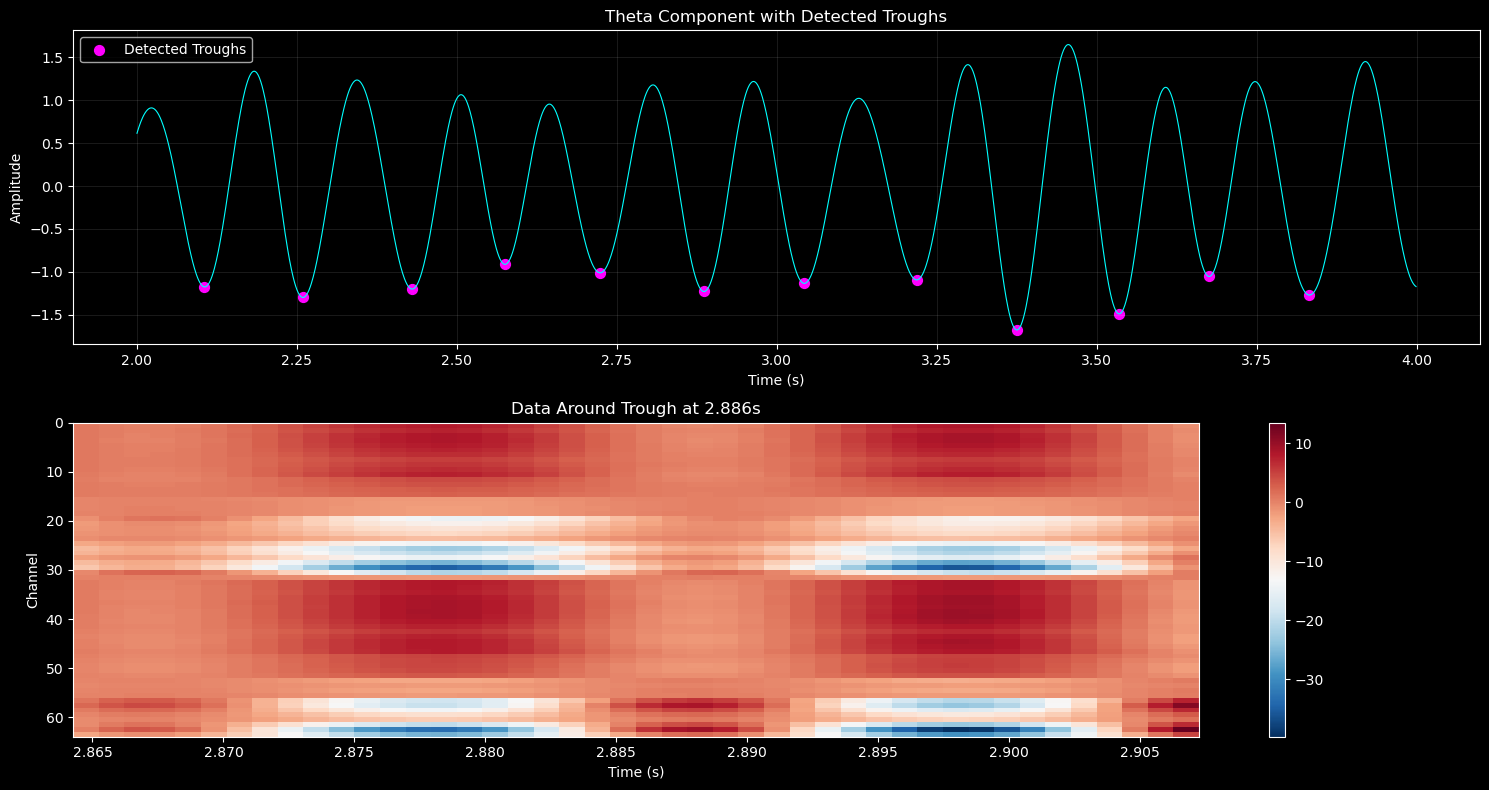


=== Trough Window Statistics ===
Window duration: 43.0 ms
Average time between troughs: 163.9 ms


In [23]:
# Create comprehensive visualization
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), facecolor='black')

# Plot 1: Theta component with marked troughs
segment = slice(int(2*srate), int(4*srate))  # 2-second segment
ax1.plot(times[segment], thetacomp[segment], color='cyan', linewidth=0.8)

# Mark troughs in the segment
troughs_in_segment = troughs[(troughs >= segment.start) & (troughs < segment.stop)]
ax1.scatter(times[troughs_in_segment], 
           thetacomp[troughs_in_segment], 
           color='magenta', 
           s=50, 
           label='Detected Troughs')

ax1.set_title('Theta Component with Detected Troughs')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.1)
ax1.legend()

# Plot 2: Example of data around one trough
example_trough = troughs_in_segment[5]  # take 5th trough in segment
trough_data = data[:, example_trough-nwin:example_trough+nwin]
im = ax2.imshow(trough_data, 
                aspect='auto', 
                cmap='RdBu_r',
                extent=[times[example_trough-nwin], times[example_trough+nwin], 
                       data.shape[0], 0])
ax2.set_title(f'Data Around Trough at {times[example_trough]:.3f}s')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Channel')
plt.colorbar(im, ax=ax2)

# Adjust appearance for dark theme
for ax in [ax1, ax2]:
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')

plt.tight_layout()
plt.show()

# Print some statistics about the trough windows
print("\n=== Trough Window Statistics ===")
print(f"Window duration: {2*nwin/srate*1000:.1f} ms")
print(f"Average time between troughs: {np.mean(np.diff(times[troughs]))*1000:.1f} ms")

In [24]:
# GED for PAC
# Regularize covariance matrices first
covT_reg = regularize_cov(covT)
bbcov_reg = regularize_cov(bbcov)

# GED for PAC
evals_pac, evecs_pac = linalg.eigh(covT_reg, bbcov_reg)

# Find best component and compute filter projection
maxcomp_pac = np.argsort(evals_pac)  # Get indices of sorted eigenvalues
pac_map = covT @ evecs_pac  # Forward model using original (non-regularized) covariance
pac_map = pac_map[:, maxcomp_pac[-1]]  # Take component with largest eigenvalue

# Get PAC time series
pac_ts = data.T @ evecs_pac[:, maxcomp_pac[-1]]

# Print some verification info
print("=== PAC Analysis ===")
print(f"Number of components: {len(evals_pac)}")
print(f"Eigenvalue range: {evals_pac.min():.3f} to {evals_pac.max():.3f}")
print(f"PAC time series shape: {pac_ts.shape}")

=== PAC Analysis ===
Number of components: 64
Eigenvalue range: 0.312 to 3.701
PAC time series shape: (10241,)


GAMMA NETWORKS

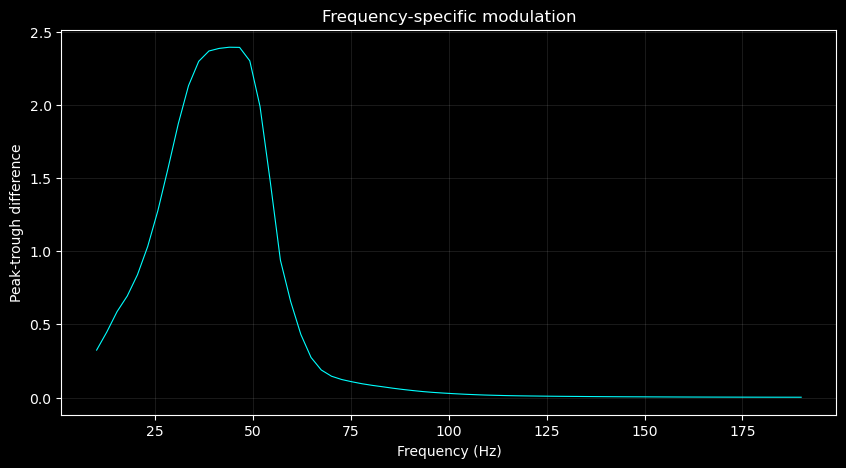

In [28]:
def filterFGx(data, srate, center_freq, half_width):
    """
    Filter data around center frequency with specified bandwidth
    """
    nyq = srate/2
    
    # Ensure filter frequencies are positive and below Nyquist
    lower_freq = max(0.001, center_freq - half_width)  # Prevent zero/negative frequencies
    upper_freq = min(nyq - 0.001, center_freq + half_width)  # Prevent above Nyquist
    
    # Check if frequencies are valid
    if lower_freq >= upper_freq:
        return np.zeros_like(data)  # Return zeros if frequencies invalid
        
    # Create and apply filter
    b, a = signal.butter(2, [lower_freq/nyq, upper_freq/nyq], btype='band')
    return signal.filtfilt(b, a, data)

# Rest of the gamma networks code remains the same
evals_pac, evecs_pac = linalg.eigh(covT_reg, bbcov_reg)
compidx = np.argsort(evals_pac)
maps = covT @ evecs_pac
gamnet1 = maps[:, compidx[-1]]

# Fix sign
idx = np.argmax(np.abs(gamnet1))
gamnet1 = gamnet1 * np.sign(gamnet1[idx])

# Frequency analysis
frex = np.linspace(10, 190, 70)
mvarpac = np.zeros(len(frex))

for fi, freq in enumerate(frex):
    gam1comp = filterFGx(data, srate, freq, 15).T @ evecs_pac[:, compidx[-1]]
    
    diff1 = np.diff(gam1comp)
    troughs = np.where(np.diff(np.sign(diff1)) > 0)[0] + 1
    peaks = np.where(np.diff(np.sign(diff1)) < 0)[0] + 1
    
    mvarpac[fi] = np.mean(gam1comp[peaks]) - np.mean(gam1comp[troughs])

# Plot results
plt.style.use('dark_background')
plt.figure(figsize=(10, 5), facecolor='black')
plt.plot(frex, mvarpac, color='cyan', linewidth=0.8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Peak-trough difference')
plt.title('Frequency-specific modulation')
plt.grid(True, alpha=0.1)
plt.show()

In [29]:
# Get PAC value from the gamma band peak (around 40-50 Hz)
gamma_band_idx = np.logical_and(frex >= 35, frex <= 55)
pac_value = np.max(mvarpac[gamma_band_idx])

print("Original PAC value:", pac_value)

Original PAC value: 2.3939502451653656


In [30]:
# Frequency of maximum modulation
gamma_freq = frex[np.argmax(mvarpac)]
print(f"Gamma frequency at max PAC: {gamma_freq:.1f} Hz")

Gamma frequency at max PAC: 43.9 Hz


In [31]:
# Find width at half maximum
half_max = np.max(mvarpac) / 2
above_half = mvarpac >= half_max
width_indices = np.where(above_half)[0]
mod_width = frex[width_indices[-1]] - frex[width_indices[0]]
print(f"Modulation width: {mod_width:.1f} Hz")

Modulation width: 28.7 Hz


In [32]:
# Area under the curve
total_mod = np.trapz(mvarpac, frex)
print(f"Total modulation: {total_mod:.1f}")

Total modulation: 83.2
